In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from sklearn.cluster import KMeans
import numpy as np

import os
import json
import pandas as pd
import collections
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

### **Utility functions**

In [2]:
def box_corner_to_center(boxes):
    """
    boxes: (num_boxes, x1, y1, x2, y2)
    where (x1,y1) is the upper corner left coordinate
    and   (x2, y2) is the bottom corner right coo
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

def draw_bbox(image, coords):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    x_min, x_max, y_min, y_max = coords
    rect = plt.Rectangle((x_min * 256.0, y_min * 256.0), 
                         x_max * 256.0 - x_min * 256.0, 
                         y_max * 256.0 - y_min * 256.0, 
                         linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [3]:
class CreateAnchorBoxes:
    """
    Takes image scale size to generate coordinates of all anchor boxes given ratios and sizes.
    
    image: (batch_size, channel, width, height)
    sizes: 1D list
    ratios: 1D list
    """
    def __init__(self, image, sizes, ratios):
        self.image_height, self.image_width = image.shape[-2], image.shape[-1]
        self.sizes = torch.tensor(sizes, device='cuda')
        self.ratios = torch.tensor(ratios, device='cuda')
        self.num_boxes = len(sizes) * len(ratios)
        self.create_grid_center_points()
        self.create_anchor_width_height()

    def create_grid_center_points(self):
        self.center_x_axis = (torch.arange(self.image_width, device='cuda') + 0.5) / self.image_width
        self.center_y_axis = (torch.arange(self.image_height, device='cuda') + 0.5) / self.image_height
        self.grid_x_coords, self.grid_y_coords = torch.meshgrid(self.center_x_axis, self.center_y_axis)
        self.grid_x_coords = self.grid_x_coords.reshape(-1)
        self.grid_y_coords = self.grid_y_coords.reshape(-1)

    def create_anchor_width_height(self):
        width_anchor = torch.tensor([], device='cuda')
        height_anchor = torch.tensor([], device='cuda')

        for size in self.sizes:
            for ratio in self.ratios:
                width_anchor = torch.cat((width_anchor, size * torch.sqrt(ratio).unsqueeze(0)))
                height_anchor = torch.cat((height_anchor, size / torch.sqrt(ratio).unsqueeze(0)))

        self.grid_width_height = torch.stack(
            (-width_anchor, -height_anchor,
             width_anchor, height_anchor)
        ).T.repeat(self.image_height * self.image_width, 1) / 2

    def mapping(self):
        out_grid = torch.stack(
            [self.grid_x_coords, self.grid_y_coords,
             self.grid_x_coords, self.grid_y_coords],
            dim=1).repeat_interleave(self.num_boxes, dim=0)
        return out_grid + self.grid_width_height
    
    
def multibox_prior(data, sizes, ratios):
    # Get height and width of the input tensor
    in_height, in_width = data.shape[-2:]

    # Determine device and other relevant constants
    device = data.device
    num_sizes, num_ratios = len(sizes), len(ratios)
    boxes_per_pixel = num_sizes + num_ratios - 1

    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    offset_h, offset_w = 0.5, 0.5
    steps_h, steps_w = 1.0 / in_height, 1.0 / in_width

    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Compute anchor box widths and heights
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))

    # Create anchor box manipulations
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    # Generate the grid of shifts
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations

    return output.unsqueeze(0)

In [4]:
def calculate_box_area(boxes):
    return ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])).cuda()

def BoxIou(boxes1, boxes2):
    boxes1 = boxes1.cuda()
    boxes2 = boxes2.cuda()

    areas1 = calculate_box_area(boxes1)
    areas2 = calculate_box_area(boxes2)

    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)

    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas


def assign_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.5):
    
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    jaccard = BoxIou(anchors, ground_truth)

    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device="cuda")

    max_ious, indices = torch.max(jaccard, dim=1)
    if isinstance(iou_threshold, float):
        iou_threshold = torch.tensor(iou_threshold, device=max_ious.device)
        
    anc_i = torch.nonzero(max_ious >= iou_threshold, as_tuple=False).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j

    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
        
    return anchors_bbox_map

In [5]:
def offset_boxes(anchors, assigned_bboxes, sigma_xy=0.1, sigma_wh=0.2, mean=0, eps=1e-6):
    center_anchors = box_corner_to_center(anchors.cuda())
    center_assigned_bboxes = box_corner_to_center(assigned_bboxes.cuda())
    offset_xy = ((center_assigned_bboxes[:, :2] - center_anchors[:, :2]) / center_anchors[:, 2:] - mean) / sigma_xy
    offset_wh = (torch.log(eps + center_assigned_bboxes[:, 2:] / center_anchors[:, 2:] - mean)) / sigma_wh
    offset = torch.cat([offset_xy, offset_wh], dim=1)
    return offset


def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    num_anchors = anchors.shape[0]
    
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)

        class_labels = torch.zeros(num_anchors, dtype=torch.long, device="cuda")
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device="cuda")

        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        print("bb_idx: ", bb_idx.shape)
        
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]

        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

### **Backbone**

In [6]:
base = timm.create_model('xcit_tiny_24_p16_384.fb_dist_in1k', pretrained=True)
data_config = timm.data.resolve_model_data_config(base)
data_config

{'input_size': (3, 384, 384),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 1.0,
 'crop_mode': 'center'}

In [7]:
transforms = timm.data.create_transform(**data_config, is_training=False)
transforms

Compose(
    Resize(size=384, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [8]:
x = Image.open("../dataset/Car/ds/img/Cars10.png").convert("RGB")
input = transforms(x).unsqueeze(0)
input.shape

torch.Size([1, 3, 384, 384])

In [9]:
output = base.forward_intermediates(input, intermediates_only=True, indices=[23])[0]
output.shape

torch.Size([1, 192, 24, 24])

In [10]:
x = torch.rand(1, 3, 384, 384)
output = base.forward_intermediates(x, intermediates_only=True, indices=[23])[0]
output.shape

torch.Size([1, 192, 24, 24])

In [11]:
# We have 5 scales
depths = [192, 192, 192, 192, 192]
width =  [24, 12,   6,   3,   1]
height = [24, 12,   6,   3,   1]


X_multiscale = [
    torch.randn(1, depths[0], width[0], height[0]),
    torch.randn(1, depths[1], width[1], height[1]),
    torch.randn(1, depths[2], width[2], height[2]),
    torch.randn(1, depths[3], width[3], height[3]),
    torch.randn(1, depths[4], width[4], height[4]),
]

# sizes = [[0.2,  0.272], 
#          [0.37, 0.447], 
#          [0.54, 0.619], 
#          [0.71, 0.79], 
#          [0.88, 0.961]]

sizes = [[0.67    , 0.54088159],
        [0.98014493, 0.74584459],
        [0.57121795, 0.77929886],
        [0.82436275, 0.63897197],
        [0.66794872, 0.42594524]]

sizes = (np.array(sizes) / 3).tolist()

ratios = [[1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5]]

num_anchors_per_pixel = len(sizes[0]) * len(ratios[0]) - 2
print(f"Each group (pixel) has {num_anchors_per_pixel} anchor boxes")

Each group (pixel) has 4 anchor boxes


#### **K-means for sizes**

In [12]:
json_files = glob("../dataset/Car/ds/ann/*.json")

data = []
for file in json_files:
    with open(file, 'r') as f:
        # Load the JSON data
        content = json.load(f)
        
        # Extract the relevant information from the JSON
        for obj in content['objects']:
            obj_id = obj['id']
            x_min = obj['points']['exterior'][0][0]
            y_min = obj['points']['exterior'][0][1]
            x_max = obj['points']['exterior'][1][0]
            y_max = obj['points']['exterior'][1][1]
            width = content['size']['width']
            height = content['size']['height']
            
            # Append the data to the list
            data.append({
                'id': obj_id,
                'name': os.path.basename(file)[:-5],
                'class': 0,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'width': width,
                'height': height
            })
            break


df = pd.DataFrame(data)
df.to_csv("../dataset/Car/ds/meta.csv", index=False)
df

,id,name,class,x_min,x_max,y_min,y_max,width,height
0,6325281,Cars0.png,0,226,419,125,173,500,268
1,6325304,Cars1.png,0,134,262,128,160,400,248
2,6325367,Cars10.png,0,140,303,5,148,400,225
3,6325292,Cars100.png,0,175,214,114,131,400,267
4,6325320,Cars101.png,0,167,240,202,220,400,300
...,...,...,...,...,...,...,...,...,...
428,6325238,Cars95.png,0,278,407,182,263,600,400
429,6325206,Cars96.png,0,133,261,126,160,400,248
430,6325194,Cars97.png,0,98,297,102,191,400,300
431,6325459,Cars98.png,0,85,247,196,259,370,400


### **Normal Kmeans**

In [15]:
df['norm_width'] = df['width'] / df['width'].max()
df['norm_height'] = df['height'] / df['height'].max()
df

,id,name,class,x_min,x_max,y_min,y_max,width,height,norm_width,norm_height
0,6325281,Cars0.png,0,226,419,125,173,500,268,0.833333,0.504708
1,6325304,Cars1.png,0,134,262,128,160,400,248,0.666667,0.467043
2,6325367,Cars10.png,0,140,303,5,148,400,225,0.666667,0.423729
3,6325292,Cars100.png,0,175,214,114,131,400,267,0.666667,0.502825
4,6325320,Cars101.png,0,167,240,202,220,400,300,0.666667,0.564972
...,...,...,...,...,...,...,...,...,...,...,...
428,6325238,Cars95.png,0,278,407,182,263,600,400,1.000000,0.753296
429,6325206,Cars96.png,0,133,261,126,160,400,248,0.666667,0.467043
430,6325194,Cars97.png,0,98,297,102,191,400,300,0.666667,0.564972
431,6325459,Cars98.png,0,85,247,196,259,370,400,0.616667,0.753296


In [16]:
X = df[['norm_width', 'norm_height']]

kmeans = KMeans(n_clusters=5, random_state=0)
df['anchor_box'] = kmeans.fit_predict(X)
anchor_sizes = kmeans.cluster_centers_
anchor_sizes

array([[0.67      , 0.54088159],
       [0.98014493, 0.74584459],
       [0.57121795, 0.77929886],
       [0.82436275, 0.63897197],
       [0.66794872, 0.42594524]])

#### **Visualization of distribution**

In [13]:
def change_to_wh(data):
    data['w'] = data['x_max'] - data['x_min'] + 1
    data['h'] = data['y_max'] - data['y_min'] + 1
    return data

data = change_to_wh(df)
data

,id,name,class,x_min,x_max,y_min,y_max,width,height,w,h
0,6325281,Cars0.png,0,226,419,125,173,500,268,194,49
1,6325304,Cars1.png,0,134,262,128,160,400,248,129,33
2,6325367,Cars10.png,0,140,303,5,148,400,225,164,144
3,6325292,Cars100.png,0,175,214,114,131,400,267,40,18
4,6325320,Cars101.png,0,167,240,202,220,400,300,74,19
...,...,...,...,...,...,...,...,...,...,...,...
428,6325238,Cars95.png,0,278,407,182,263,600,400,130,82
429,6325206,Cars96.png,0,133,261,126,160,400,248,129,35
430,6325194,Cars97.png,0,98,297,102,191,400,300,200,90
431,6325459,Cars98.png,0,85,247,196,259,370,400,163,64


In [14]:
def compute_new_static_size(width, height, min_dim, max_dim):
    orig_height = height
    orig_width = width
    orig_min_dim = min(orig_height, orig_width)
    
    # Calculate the larger of possible sizes
    large_scale_factor = min_dim / float(orig_min_dim)
    large_height = int(round(orig_height * large_scale_factor))
    large_width = int(round(orig_width * large_scale_factor))
    large_size = [large_height, large_width]
    
    if max_dim:
        orig_max_dim = max(orig_height, orig_width)
        small_scale_factor = max_dim / float(orig_max_dim)
        small_height = int(round(orig_height * small_scale_factor))
        small_width = int(round(orig_width * small_scale_factor))
        small_size = [small_height, small_width]
        new_size = large_size
        
    if max(large_size) > max_dim:
        new_size = small_size
    else:
        new_size = large_size
    
    return new_size[1], new_size[0]

In [15]:
min_dim = 600
max_dim = 1024

data['new_w'], data['new_h'] = np.vectorize(compute_new_static_size)(data['width'],  data['height'], min_dim, max_dim)
data

,id,name,class,x_min,x_max,y_min,y_max,width,height,w,h,new_w,new_h
0,6325281,Cars0.png,0,226,419,125,173,500,268,194,49,1024,549
1,6325304,Cars1.png,0,134,262,128,160,400,248,129,33,968,600
2,6325367,Cars10.png,0,140,303,5,148,400,225,164,144,1024,576
3,6325292,Cars100.png,0,175,214,114,131,400,267,40,18,899,600
4,6325320,Cars101.png,0,167,240,202,220,400,300,74,19,800,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,6325238,Cars95.png,0,278,407,182,263,600,400,130,82,900,600
429,6325206,Cars96.png,0,133,261,126,160,400,248,129,35,968,600
430,6325194,Cars97.png,0,98,297,102,191,400,300,200,90,800,600
431,6325459,Cars98.png,0,85,247,196,259,370,400,163,64,600,649


In [16]:
data['b_w'] = data['new_w'] * data['w']/ data['width']
data['b_h'] = data['new_h'] * data['h'] / data['height']
data['b_ar'] = data['b_w'] / data['b_h']
data

,id,name,class,x_min,x_max,y_min,y_max,width,height,w,h,new_w,new_h,b_w,b_h,b_ar
0,6325281,Cars0.png,0,226,419,125,173,500,268,194,49,1024,549,397.312000,100.376866,3.958203
1,6325304,Cars1.png,0,134,262,128,160,400,248,129,33,968,600,312.180000,79.838710,3.910133
2,6325367,Cars10.png,0,140,303,5,148,400,225,164,144,1024,576,419.840000,368.640000,1.138889
3,6325292,Cars100.png,0,175,214,114,131,400,267,40,18,899,600,89.900000,40.449438,2.222528
4,6325320,Cars101.png,0,167,240,202,220,400,300,74,19,800,600,148.000000,38.000000,3.894737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,6325238,Cars95.png,0,278,407,182,263,600,400,130,82,900,600,195.000000,123.000000,1.585366
429,6325206,Cars96.png,0,133,261,126,160,400,248,129,35,968,600,312.180000,84.677419,3.686697
430,6325194,Cars97.png,0,98,297,102,191,400,300,200,90,800,600,400.000000,180.000000,2.222222
431,6325459,Cars98.png,0,85,247,196,259,370,400,163,64,600,649,264.324324,103.840000,2.545496


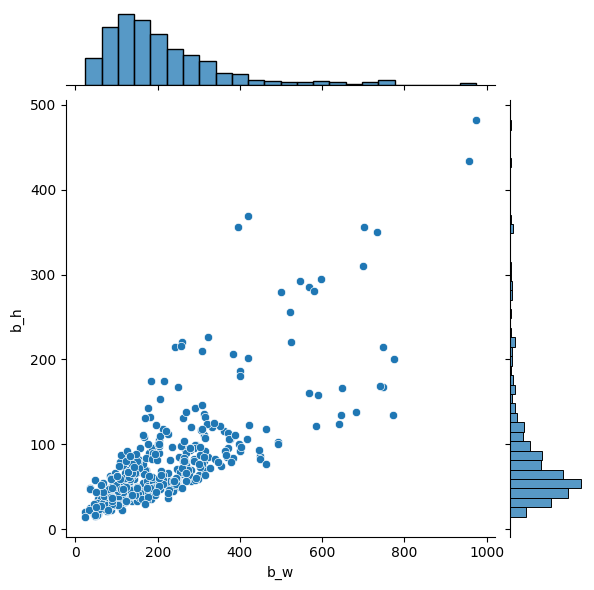

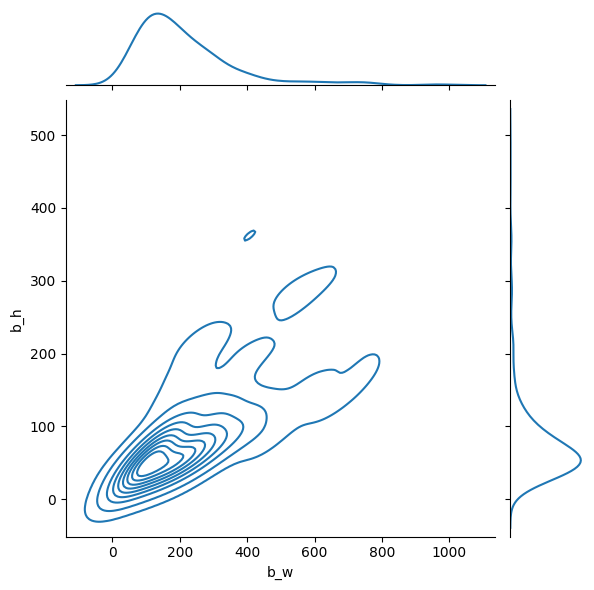

In [17]:
sns.jointplot(x="b_w", y="b_h", data=data)
sns.jointplot(x="b_w", y="b_h", data=data, kind='kde')

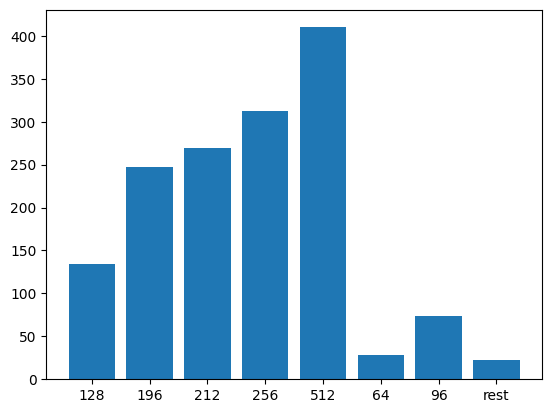

In [18]:
def count_base_size(width, height, input_array=[64, 96, 128, 196, 212, 256, 512]):
    result = {}
    for ele in input_array:
        result[str(ele)] = 0
    result['rest'] = 0
    
    for w, h in zip(width, height):
        done = False
        for inp in input_array:
            if w <= inp and h <= inp:
                result[str(inp)] += 1
                done = True
        if not done:
            result['rest'] += 1
            
    return result
    
D = count_base_size(data["b_w"].tolist(), data["b_h"].tolist())
OD = collections.OrderedDict(sorted(D.items()))
plt.bar(range(len(OD)), OD.values(), align='center')
plt.xticks(range(len(OD)), OD.keys())
plt.show()

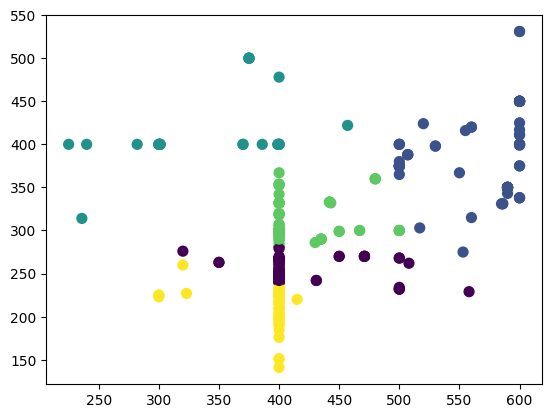

In [19]:
X = data[['width', 'height']].values
K = KMeans(5, random_state=0)
labels = K.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=labels.labels_, s=50, cmap='viridis')

In [ ]:
out = labels.cluster_centers_
ar = out[:,0] / out[:,1]
scale = out[:,1] * np.sqrt(ar) / 256

print("Aspect Ratios: {}".format(ar))
print("Scales: {}".format(scale))

#### **IOU-based clustering**

In [21]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [13]:
def prepare_anchor_boxes(X_multiscale, sizes, ratios, num_anchors_per_pixel):
    
    anchors_multiscale = []

    for i in range(len(X_multiscale)):

        anchors = multibox_prior(X_multiscale[i], sizes[i], ratios[i])
        anchors_multiscale.append(anchors)
        
        total_anchors = X_multiscale[i].shape[2] * X_multiscale[i].shape[3] * num_anchors_per_pixel
        print(f"Total anchor boxes are: {total_anchors} -> anchor shape: {anchors.shape}")
        
    anchors_multiscale = torch.cat(anchors_multiscale, dim=1)
    return anchors_multiscale
        
anchors_multiscale = prepare_anchor_boxes(X_multiscale, sizes, ratios, num_anchors_per_pixel)
print(anchors_multiscale.shape)

Total anchor boxes are: 2304 -> anchor shape: torch.Size([1, 2304, 4])
Total anchor boxes are: 576 -> anchor shape: torch.Size([1, 576, 4])
Total anchor boxes are: 144 -> anchor shape: torch.Size([1, 144, 4])
Total anchor boxes are: 36 -> anchor shape: torch.Size([1, 36, 4])
Total anchor boxes are: 4 -> anchor shape: torch.Size([1, 4, 4])
torch.Size([1, 3064, 4])


### **Prepare Network**

In [15]:
class Downsampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        return self.layers(x)
        
class BaseNet(nn.Module):
    def __init__(self, base_net):
        super().__init__()
        self.base_net = base_net
        
    def forward(self, x):
        x =  self.base_net.forward_intermediates(x, intermediates_only=True, indices=[23])[0]
        return x
    
class ScaleModule(nn.Module):
    def __init__(self, in_channel, out_channel, num_classes, num_anchors, baseNet=None, avg_pool=False):
        super().__init__()
        
        if baseNet is not None:
            self.downsample = baseNet
        elif avg_pool:
            self.downsample = nn.AdaptiveMaxPool2d((1,1))
        else:
            self.downsample = Downsampling(in_channel, out_channel)
            
        self.cls_head = nn.Conv2d(out_channel, num_anchors * (num_classes + 1), kernel_size=3, padding=1)
        self.bbox_head = nn.Conv2d(out_channel, num_anchors * 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.downsample(x)
        cls_pred = self.cls_head(x)
        bbox_pred = self.bbox_head(x)
        return x, cls_pred, bbox_pred
    

class SSD(nn.Module):
    def __init__(self, num_classes, num_anchors, base_net):
        super().__init__()
        self.num_classes = num_classes
        self.base_net = BaseNet(base_net)
        self.scale_module_1 = ScaleModule(3, 192, num_classes, num_anchors, baseNet=self.base_net)
        self.scale_module_2 = ScaleModule(192, 192, num_classes, num_anchors)
        self.scale_module_3 = ScaleModule(192, 192, num_classes, num_anchors)
        self.scale_module_4 = ScaleModule(192, 192, num_classes, num_anchors)
        self.scale_module_5 = ScaleModule(192, 192, num_classes, num_anchors, avg_pool=True)
        
    def flatten_pred(self, pred):
        return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
        
    def concat_preds(self, preds):
        return torch.cat([self.flatten_pred(pred) for pred in preds], dim=1)
        
    def post_process(self):
        self.cls_preds = self.concat_preds(self.cls_preds)
        self.cls_preds = self.cls_preds.reshape(self.cls_preds.shape[0], -1, self.num_classes + 1)
        self.bbox_preds = self.concat_preds(self.bbox_preds)
            
    def forward(self, x):
        
        self.cls_preds, self.bbox_preds = [], []
        
        x, cls_pred, bbox_pred = self.scale_module_1(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_2(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_3(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_4(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_5(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        self.post_process()
        
        return x, self.cls_preds, self.bbox_preds

In [16]:
X = torch.randn(1, 3, 384, 384).cuda()
model = SSD(num_classes=1, num_anchors=4, base_net=base).cuda()
x_, cls_preds, bbox_preds = model(X)
x_.shape, anchors_multiscale.shape, cls_preds.shape, bbox_preds.shape

(torch.Size([1, 192, 1, 1]),
 torch.Size([1, 3064, 4]),
 torch.Size([1, 3064, 2]),
 torch.Size([1, 12256]))

### **Data preparation**

In [19]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, ds_dir, transform):
        self.img_dir = os.path.join(ds_dir, 'img')
        self.img_paths = glob(os.path.join(self.img_dir, "*.png"))
        self.data_frame = pd.read_csv(os.path.join(ds_dir, 'meta.csv'))
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        x = self.transform(Image.open(self.img_paths[index]).convert("RGB"))
        name = os.path.basename(self.img_paths[index])
        target = self.data_frame.loc[
            self.data_frame['name'] == name, 
            ['class', 'x_min', 'x_max', 'y_min', 'y_max']
        ].values.tolist()
        
        return x, torch.tensor(np.array(target)).to(torch.float32)
    
data_loader = torch.utils.data.DataLoader(
    CarDataset(
        ds_dir='../dataset/Car/ds/',
        transform=transforms
    ),
    batch_size=12, 
    shuffle=True
)

In [20]:
for input, target in data_loader:
    print(input.shape)
    print(target.shape)
    break

torch.Size([12, 3, 384, 384])
torch.Size([12, 1, 5])


In [ ]:
model = SSD(num_classes=1, num_anchors=4, base_net=base).cuda()
model.load_state_dict(torch.load("../.cache/models/"))

### **Training**

In [21]:
num_epochs = 20
model = SSD(num_classes=1, num_anchors=4, base_net=base).cuda()

cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    
    cls = cls_loss(
        cls_preds.reshape(-1, num_classes),
        cls_labels.reshape(-1)
    ).reshape(batch_size, -1).mean(dim=1)
    
    bbox = bbox_loss(
        bbox_preds * bbox_masks,
        bbox_labels * bbox_masks
    ).mean(dim=1)
    
    return cls + bbox

optimizer = torch.optim.SGD(model.parameters(), lr=0.2, weight_decay=5e-4)

In [22]:
class Accumulator:

    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
metric = Accumulator(4)

In [23]:
def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [24]:
min_cls_err = 100000
min_bbox_mae = 100000 

for epoch in range(num_epochs):
    model.train()
    for X, Y in data_loader:
        optimizer.zero_grad()
        X = X.cuda()
        Y = Y.cuda()
        x_, cls_preds, bbox_preds = model(X)
    
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors_multiscale, Y)
        loss = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks).mean()
        
        loss.backward()
        optimizer.step()
        metric.add (
            cls_eval(cls_preds, cls_labels), 
            cls_labels.numel(),
            bbox_eval(bbox_preds, bbox_labels, bbox_masks),
            bbox_labels.numel()
        )
        
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    print(f"Epoch: {epoch+1} --- Class error: {cls_err} --- Box MAE: {bbox_mae}")
    
    if (cls_err < min_cls_err):
        min_loss = loss
        min_bbox_mae = bbox_mae
        torch.save(model.state_dict(), "../.cache/models/ssd_car.pt")

print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')

torch.Size([12, 3064, 2]) torch.Size([12, 12256])
torch.Size([12, 12256]) torch.Size([12, 12256]) torch.Size([12, 3064])


### **Non-max Suppression**

In [31]:
def offset_inverse(anchors, offset_preds):
    
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

def nms(boxes, scores, iou_threshold):
    
    """Sort confidence scores of predicted bounding boxes."""
    
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = [] 
    
    while B.numel() > 0:
        i = B[0]
        keep.append(i)        
        if B.numel() == 1: break

        iou = BoxIou(
            boxes[i, :].reshape(-1, 4),
            boxes[B[1:], :].reshape(-1, 4)
        ).reshape(-1)
        
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
        
    return torch.tensor(keep, device=boxes.device)

In [32]:
def multibox_detection(
    cls_probs, offset_preds, 
    anchors, nms_threshold=0.5,
    pos_threshold=0.009999999
):
    
    """Predict bounding boxes using non-maximum suppression."""
    
    batch_size = cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_anchors = cls_probs.shape[2]
    out = []
    
    for i in range(batch_size):
        
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        
        # Find all non-`keep` indices and set the class to background
        
        all_idx = torch.arange(num_anchors, dtype=torch.long, device="cuda")
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        
        pred_info = torch.cat((
            class_id.unsqueeze(1),
            conf.unsqueeze(1),
            predicted_bb), dim=1)
        
        out.append(pred_info)
        
    return torch.stack(out)

In [66]:
img = Image.open("../dataset/Car/ds/img/Cars10.png").convert("RGB").resize((384, 384))
image = np.array(img)
x = transforms(img).unsqueeze(0)

### **Inference**

In [60]:
def predict(X):
    model.eval()
    x_, cls_preds, bbox_preds = model(X.cuda())
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors_multiscale.cuda())
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

In [62]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""

    return plt.Rectangle (
        xy=(bbox[0], bbox[1]), 
        width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2
    )

In [63]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['r', 'r', 'r', 'r', 'r'])
    
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(
                rect.xy[0], rect.xy[1], labels[i],
                va='center', ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0)
            )

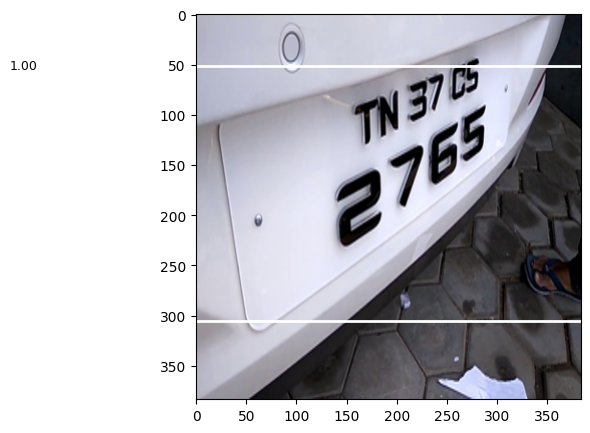

In [49]:
def display(img, output, threshold):
    plt.figure(figsize=(5, 5))
    fig = plt.imshow(img)
    
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(image, output.cpu(), threshold=0.9)